# Comparing two ratios

## Vocabulary

This example uses the **binomial distribution** as well as the **beta distribution.** Consider skimming the Wikipedia pages if you're not familiar with them. The beta is conjugate to the binomial so you'll see the two together frequently.

## The problem

**Note:** This example is ripped off from the excellent repository here: https://jrnold.github.io/bugs-examples-in-stan/undervote

The type of question we're going to answer is a common one- if we estimate fraction from different datasets, how do we decide whether a difference is significant? Or whether different datasets are consistent with each other?

The specific question is whether there's a racial gap in undervoting in the US presidential race. The data below are counts from two polls (Voter News Service (VNS) exit poll for the 1992 election and American National Election Studies (ANES) for the 1964–2000 elections), giving the count (broken out by race) of people who reported voting in the election but didn't fill in a candidate for president.

## Bayesian statistics is not the only way to answer this

It would be perfectly acceptable to compute standard polling errors and see whether they overlap. There may also be any number of frequentist hypothesis test statistics you could compute for this problem. All are perfectly acceptable approaches.

One thing that's convenient about the Bayesian approach is that we can model the thing we're interested (the **difference** in ratios by race) directly. This ability will really shine when we want to build more complicated models (where it'd be difficult to design a frequentist estimator).

## Getting started

Import libraries and set up the data as a DataFrame:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pystan

%matplotlib inline

In [2]:
df = pd.DataFrame({
    "survey":["VNS", "VNS", "ANES", "ANES"],
    "race":["black", "white", "black", "white"],
    "n":[6537, 44531, 1101, 9827],
    "undervote":[26, 91, 10, 57]
})

In [3]:
df.head()

,survey,race,n,undervote
0,VNS,black,6537,26
1,VNS,white,44531,91
2,ANES,black,1101,10
3,ANES,white,9827,57


## Making an initial point estimate

If we didn't know that statistics was a thing, we'd just compute the rates by dividing `undervote` by `n`. Let's do that (and compute differences between race) for each survey:

In [4]:
# VNS point estimate of delta
r_black = 26/6537 
r_white = 91/44531
print("VNS black undervote rate:", round(r_black,5))
print("VNS white undervote rate:", round(r_white,5))

delta_vns = r_black - r_white
print("VNS delta:", round(delta_vns,5))

VNS black undervote rate: 0.00398
VNS white undervote rate: 0.00204
VNS delta: 0.00193


In [5]:
# ANES point estimate of delta
r_black = 10/1101 
r_white = 57/9827
print("VNS black undervote rate:", round(r_black,5))
print("VNS white undervote rate:", round(r_white,5))

delta_anes = r_black - r_white
print("anes delta:", round(delta_anes,5))

VNS black undervote rate: 0.00908
VNS white undervote rate: 0.0058
anes delta: 0.00328


But unfortunately we do know about statistics. So now that we have a simple answer that was easy to compute, we have to dive into an existential void of self-doubt:

* Those deltas are pretty small- 0.2% and 0.3%. Could it be that there's actually no difference and we're looking at sampling error?
*  Even if the difference is real- the surveys gave different results? How big of a difference could there be before we'd decide that they're inconsistent with each other?

## The model

Let's start formalizing the problem into a model.

For survey $i$ and race $j$, there's some (unknown) probability $\theta_{ij}$ of undervoting. 

The latent variable we're interested in, for survery $i$, is

$\delta_{i} = \theta_{i,black} - \theta_{i,white}$

To compute this, we'll need to put a prior over the probabilities $p(\theta_{ij})$ and relate them to the observed undervote counts $y_{ij}$.

Since we're dealing with binary counts, the binomial is a natural distribution to use:

$y_{ij} \sim Bin\left(N_{ij}, \theta_{ij}\right)$

For the prior- the Beta distribution is conjugate to the Binomial:

$\theta_{ij} \sim Beta(a,b)$

where $a$ and $b$ are the prior hyperparameters we'll set. Using $(1,1)$ would give us a uniform prior if we want to start simple:

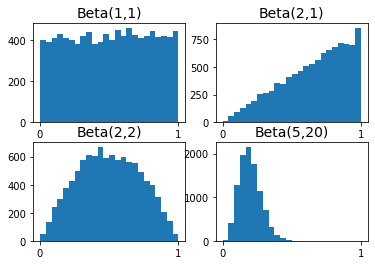

In [6]:
i = 1
for a,b in [(1,1), (2,1), (2,2), (5,20)]:
    plt.subplot(2,2,i)
    _ = plt.hist(np.random.beta(a,b, 10000), bins=np.linspace(0,1,25))
    plt.title("Beta(%s,%s)"%(a,b), fontsize=14)
    plt.xticks([0,1])
    i += 1

Now write a stan model to do inference over the $\theta$'s. Here's some skeleton code to get you started:

```
model_code = """

data {
  // you'll need variables for n and y.
  // both will need a [4] after them.
}
parameters {
  // the thetas are the only parameters. same deal on the [4].
  // also, I had initialization errors until I manually constrained
  // the lower and upper bounds.
}
model {
  // write the prior over theta, and
  // the likelihood of y as a function of n and theta
}
generated quantities {
  // finally, just for convenience- define delta_vns and 
  // delta_anes in terms of the thetas.
  real delta_vns = theta[1] - theta[2];
  real delta_anes = theta[3] - theta[4];
}
"""
```

In [7]:
# DELETE THIS FOR THE LAB
model_code = """
data {
  int n[4];
  int y[4];
}
parameters {
  real<lower=0, upper=1> theta[4];
}
model {
  theta ~ beta(1, 1);
  y ~ binomial(n, theta);
}
generated quantities {
  real delta_vns = theta[1] - theta[2];
  real delta_anes = theta[3] - theta[4];
}
"""

### Running the model

In [8]:
%%time
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2dee2760a37660c2dcc0baedcbbc484b NOW.


CPU times: user 1.36 s, sys: 96.9 ms, total: 1.45 s
Wall time: 1min 34s


In [12]:
data = {"n":df.n.values, "y":df.undervote.values}
fit = model.sampling(data=data, iter=5000, chains=4)

In [13]:
fit

Inference for Stan model: anon_model_2dee2760a37660c2dcc0baedcbbc484b.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   4.1e-3  7.3e-6 7.9e-4 2.8e-3 3.6e-3 4.1e-3 4.6e-3 5.8e-3  11702    1.0
theta[2]   2.1e-3  2.0e-6 2.1e-4 1.7e-3 1.9e-3 2.1e-3 2.2e-3 2.5e-3  11020    1.0
theta[3]  10.0e-3  2.8e-5 3.0e-3 5.0e-3 7.9e-3 9.7e-3   0.01   0.02  11803    1.0
theta[4]   5.9e-3  7.0e-6 7.7e-4 4.5e-3 5.4e-3 5.9e-3 6.4e-3 7.5e-3  12361    1.0
delta_vns  2.1e-3  7.6e-6 8.2e-4 6.1e-4 1.5e-3 2.0e-3 2.6e-3 3.8e-3  11623    1.0
delta_anes 4.1e-3  2.9e-5 3.1e-3-1.1e-3 1.9e-3 3.8e-3 6.0e-3   0.01  11809    1.0
lp__        -1254    0.02   1.41  -1258  -1255  -1254  -1253  -1253   5315    1.0

Samples were drawn using NUTS at Sat Apr  4 19:40:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potenti

### Trace diagnostics

We don't expect any computational issues with such a simple model, but since it's a good habit to be in we'll check anyway:

In [14]:
traces = fit.extract()

In [15]:
traces["theta"].shape

(10000, 4)

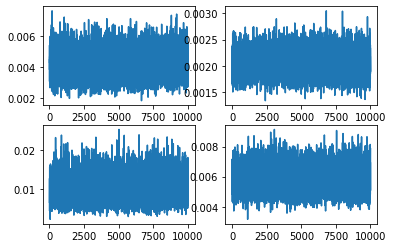

In [16]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(traces["theta"][:,i]);

## Look at the results

The values in the trace, are samples from $Pr(\delta_{vns}|X)$ and $Pr(\delta_{anes}|X)$, where $X$ is the set of observations.

We can do a quick visual check to see whether the two posteriors are consistent with each other:

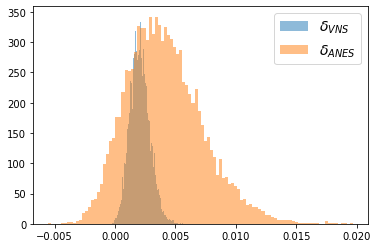

In [17]:
plt.hist(traces["delta_vns"], bins=100, alpha=0.5, label="$\delta_{VNS}$")
plt.hist(traces["delta_anes"], bins=100, alpha=0.5, label="$\delta_{ANES}$")
plt.legend(loc="upper right", fontsize=14);

These surveys were conducted by different companies over different people in different times- so there could be a lot of reasons why they may not line up, even if the underlying effect was real and consistent.

Since we have samples from the posterior, it's straightforward to make probabilistic assessments about different hypotheses- we can frame different questions depending on the decision we want to make from our analysis. For example:

What's the probability that the delta is actually zero or negative?

In [20]:
print("delta_vns:", np.mean(traces["delta_vns"] <= 0))
print("delta_anes:", np.mean(traces["delta_anes"] <= 0))

delta_vns: 0.0018
delta_anes: 0.0763


What's the probability that the size of the delta (in either direction) is less than a tenth of a percent?

In [21]:
print("delta_vns:", np.mean(np.abs(traces["delta_vns"]) < 0.001))
print("delta_anes:", np.mean(np.abs(traces["delta_anes"]) < 0.001))

delta_vns: 0.0857
delta_anes: 0.1287
